<a href="https://colab.research.google.com/github/dasdebojit/Masked-Face-detection/blob/master/masked_face_detection_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
#import Path 
import pandas as pd
import numpy as np
import cv2
import tqdm
import os
import cv2
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import sklearn 
import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)


In [ ]:
# Import Non-PyTorch Modules will be used in the lab

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from pathlib import Path
path = Path('/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1')

In [ ]:
image_names = []
form = '.jpeg'
for root, _, files in os.walk(path):
  for file_ in files:
    if( root[65] == 'N'):
      ans1 = 0
    else:
      ans1 = 1
    image_names.append([os.path.join(root, file_), ans1])
    
image_names = image_names[500:-500]
image_names[:10]

[['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0063.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0052.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0068.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0015.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0178.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0149.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0176.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0189.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0160.jpg',
  1],
 ['/content/drive/My Drive/Colab Notebooks/DL_datasets/RWMFD_part_1/0008/0073.jpg',
  1]]

In [ ]:
df = pd.DataFrame(data = image_names, columns = ['image_names', 'masked'])
df.head()

,image_names,masked
0,/content/drive/My Drive/Colab Notebooks/DL_dat...,1
1,/content/drive/My Drive/Colab Notebooks/DL_dat...,1
2,/content/drive/My Drive/Colab Notebooks/DL_dat...,1
3,/content/drive/My Drive/Colab Notebooks/DL_dat...,1
4,/content/drive/My Drive/Colab Notebooks/DL_dat...,1


In [ ]:
class Dataset(Dataset):
  def __init__(self, dataset, transform = None):
    self.df = dataset
    self.transform = transform
    self.len = len(dataset)

  def __len__(self):
    return self.len
  
  def __getitem__(self, idx):
    img_name = os.path.join(path, str(self.df.iloc[idx, 0]))
    image = Image.open(img_name)
    y = self.df.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    return image, y


In [ ]:
# i = 1
# fig = plt.figure(figsize=(10, 10))
# for image in df['image_names']:
#   img = Image.open(image)
#   ax = fig.add_subplot(1, 4, i)
#   plt.imshow(img)
#   i += 1
#   if(i == 5):
#     break
# plt.plot()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.8)
train, val = train_test_split(train, test_size = 0.1)

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.229, 0.224, 0.225] 
composed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean, std)])

In [ ]:
train_dataset = Dataset(dataset = train, transform = composed)
val_dataset = Dataset(dataset = val, transform = composed)
test_dataset = Dataset(dataset = test, transform = composed)

In [ ]:
# train_dataset[0][0].shape

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 20)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = 20)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset)

In [ ]:
#obtaining model resnet18
model = models.resnet18(pretrained = True)
for params in model.parameters():
  params.requires_grad = False

In [ ]:
model.fc = nn.Linear(512, 2)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam([params for params in model.parameters() if params.requires_grad == True], lr = 0.0004)

In [ ]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
epochs = 10
loss_list= []
acc_list = []
n_val = len(val_dataset)

for epoch in range(epochs):
  correct = 0
  loss_sublist = []
  for x_train, y_train in train_loader:
    model.train()
    z = model(x_train)
    loss = criterion(z, y_train)
    loss_sublist.append(loss.data.item())
    loss.backward()
    optim.step()
    print('/', end='')
  loss_list.append(np.mean(loss_sublist))  

  for x_val, y_val in val_loader:
    model.eval()
    z = model(x_val)
    _, yhat = torch.max(z, 1)
    correct += (yhat == y_val).sum().item()
    print('/', end = '')
  
  avg_correct = correct/n_val
  acc_list.append(avg_correct)
  print(f"Epoch[{epoch+1} / {epochs}]")
  print("-"*100)
  print(f"Training loss: {np.mean(loss_sublist)}")
  print(f"Vadliation Accuracy: {avg_correct}")
  print("-"*100)
  print("-"*100)

//////////////////////////////Epoch[1 / 10]
----------------------------------------------------------------------------------------------------
Training loss: 0.6277012132096985
Vadliation Accuracy: 0.9833333333333333
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
//////////////////////////////Epoch[2 / 10]
----------------------------------------------------------------------------------------------------
Training loss: 0.48722536241014797
Vadliation Accuracy: 0.9916666666666667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
//////////////////////////////Epoch[3 / 10]
----------------------------------------------------------------------------------------------------
Training los

Text(0.5, 1.0, 'Loss List')

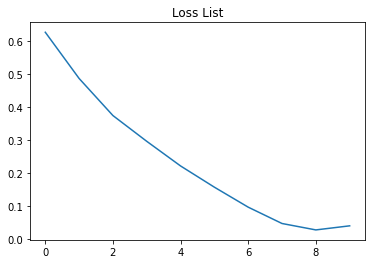

In [ ]:
plt.plot(loss_list)
plt.title('Loss List')

Text(0.5, 1.0, 'Accuracy List')

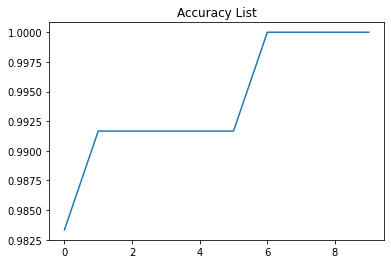

In [ ]:
plt.plot(acc_list)
plt.title('Accuracy List')

In [ ]:
#saving the model on my google drive
model_save_name = 'mask_model2.pt'
path = F"/content/drive/My Drive/Colab Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
# don't run this.. run this only when loading the model in another runtime
load_model = models.resnet18(pretrained = True)
load_model.fc = nn.Linear(512, 2)
model_save_name = 'mask_model.pt'
path = F"/content/drive/My Drive/Colab Notebooks/{model_save_name}"
load_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
correct = 0
result = []
for x_test, y_test in test_loader:
  load_model.eval()
  z = load_model(x_test)
  _, yhat = torch.max(z, 1)
  result.append(yhat)
  correct += (yhat == y_test).sum().item()
print('Accuracy: ', correct/len(test_dataset))

Accuracy:  0.9942857142857143


1


In [ ]:
inv_mean = []
inv_std = []
for i in range(len(mean)):
  inv_mean.append(-mean[i]/std[i])
  inv_std.append(1/std[i])

inv_transform = transforms.Normalize(inv_mean, inv_std)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:365: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[]

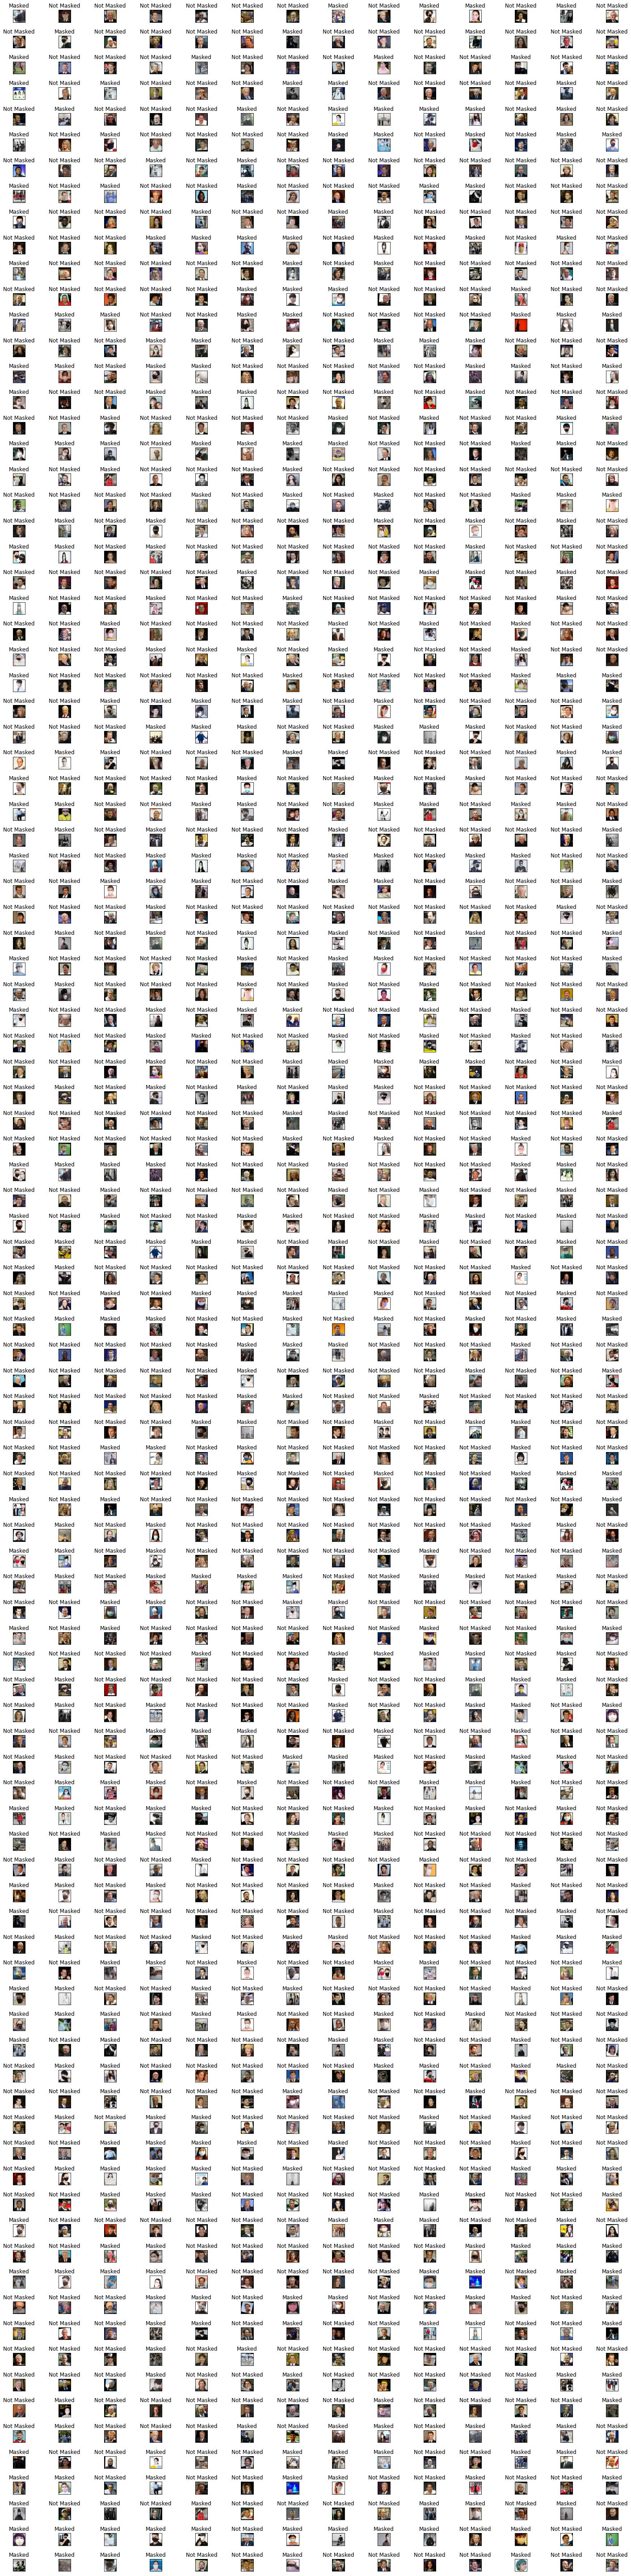

In [ ]:
# from IPython.display import display
masked = {1: 'Masked', 0: 'Not Masked'}

j = 1
fig = plt.figure(figsize=(20, 800))

for i, (x_test, y_test) in enumerate(test_loader):
  x_test = x_test.resize(3, 224, 224)
  x_test = inv_transform(x_test)
  toImage = transforms.ToPILImage()
  x_img = toImage(x_test)
  ax = fig.add_subplot(1000, 14, j)
  ax.set_title(masked[result[i].data.item()])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_img)
  j += 1
  # display(x_img)
fig.tight_layout()
plt.plot()

In [ ]:
one = 0
zero = 0
for res in result:
  if(res):
    one += 1
  else:
    zero += 1

In [ ]:
print(one, zero)

539 861


In [ ]:
print(len(result))

1400
